In [1]:
import numpy as np
import h5py
import time
import pandas as pd
import matplotlib.pyplot as plt
import glob
import scipy
import pickle as pkl
import matplotlib as mpl
from astropy.coordinates import SkyCoord
from astropy import units as u
import healpy as hp
import scipy
from scipy.optimize import differential_evolution
from matplotlib.colors import LogNorm
outpath = '/project/chihway/raulteixeira/data/'
n_deep, n_wide = 48, 26
nbins = 50
zmin, zmax = 0., 2.
deltaz = (zmax-zmin)/nbins
assert ((zmin>=0) & (zmax>=zmin) & (nbins>0) & (n_deep>0) & (n_wide>0))
z_edges = np.linspace(zmin,zmax,nbins) #np.arange(zmin,zmax,deltaz)
zs = .5*np.array([z_edges[i]+z_edges[i+1] for i in range(nbins-1)])

In [2]:
deep_cells = np.load('%s/som_DES_DF_balrog_gold+wl+fg_112623_48x48.npz'%outpath)['cells']
deep = pd.read_hdf('%s/deep_Balrog_DR3_1_1_fp_GOLD_WL_FG.hdf5'%outpath, key='df')
deep['deep_cells'] = deep_cells

In [3]:
balrog = pd.read_hdf('%s/BalrogoftheDECADE_112523_wide_cells.hdf5'%outpath, key='df')
balrog_mask = np.load('/project/chihway/raulteixeira/data/Balrog_20231125_MASK_GOLD+WL+FG.npz')['arr_0']

# zeroth order masks
balrog_fg_mask = balrog['FLAGS_FOREGROUND']==0
d_contam_arcsec  = balrog['d_contam_arcsec']
contmask = balrog['d_contam_arcsec'] > 1.5 #(d_contam_arcsec > 1.5) 
balrog['contmask'] = balrog['d_contam_arcsec'] > 1.5 #contmask
balrog_fp_mask = (balrog['true_ra'] < 180) & (balrog['true_dec'] > -25) #footprint mask for DR3_1_1

usable_balmask = balrog_fg_mask&contmask&balrog_fp_mask
# add balrog dr3_1_1 footprint cut

print(f'fraction of usable balrog injections that pass the gold cut and WL selection:\
      {np.mean(balrog_mask[usable_balmask]):.2}')

balrog = balrog[usable_balmask] #applying DR3_1_1 footprint mask, contamination mask
balrog_mask_test = balrog_mask[usable_balmask]

fraction of usable balrog injections that pass the gold cut and WL selection:      0.22


In [4]:
balrog['passes'] = balrog_mask[usable_balmask]
print(len(balrog)) #length of balrog after usable mask

balrog_deep = balrog.merge(deep, on='ID', how='left') # merge balrog w/ deep catalog for later
                                                      # will have same length as barlog catalog

3760727


In [5]:
unique_ids, counts_true = np.unique(balrog.ID.values, return_counts=True) 
# how many injections for each DF galaxy were made

unique_ids_detected, counts_detected = np.unique(balrog.ID.values[balrog.passes.values], return_counts=True)
# how many gold "detections" for each DF galaxy were made

# pandas to simplify life
df0 = pd.DataFrame()
df0['ID'] = unique_ids
df0['counts_ins'] = counts_true

df1 = pd.DataFrame()
df1['ID'] = unique_ids_detected
df1['counts_dec'] = counts_detected

df_ = df0.merge(df1, on='ID', how='left') 
# merge on id, this dataframe, df_, will have length equal to 
# the number of DF galaxies being used for balrog injections

df_['counts_dec'][np.isnan(df_['counts_dec'])] = 0 # !!! check if this is needed, 
                                                   # I can probably do this on the array to not get a warning

df_['p_pass'] = df_['counts_dec']/df_['counts_ins'] 
#p(\hat{c}) i.e., probability of passing for a given DF galaxy

balrog = balrog.merge(df_[['ID', 'p_pass']], on='ID') 
# merging to have everything under balrog and be able
# to make cell statistics of the columns generated in this cell

/tmp/ipykernel_95137/407432572.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['counts_dec'][np.isnan(df_['counts_dec'])] = 0 # !!! check if this is needed,


In [7]:
# !!!

# *Relevant* for this cell: section 5 and Appendix D in Myles, Alarcon, et. al 2021

#p(c) - i.e. probability that a galaxy in the deep fields will belong to a cell c
square_len_deep = balrog_deep[['BDF_FLUX_DERED_CALIB_I', 'deep_cells']].groupby('deep_cells').agg(['mean', 'median', 'std', len])
counts_deep = square_len_deep.BDF_FLUX_DERED_CALIB_I.len
p_c = (counts_deep/counts_deep.sum()).values.reshape(n_deep,n_deep)

#square_wide = wide['wide_cells'].groupby('wide_cells').agg(['mean', 'median', 'std', len])

# #p(\hat{c}) - i.e. probability that a galaxy in the wide fields will belong to a cell c 
# square_p_c_hat = wide[['COADD_OBJECT_ID', 'wide_cells']].groupby('wide_cells').agg([len])
# # counts_wide = square_p_c_hat.COADD_OBJECT_ID.len

# #p^W(\hat{c}) - Wide field version
# p_c_hat = counts_wide.values.reshape(n_wide,n_wide)
# p_c_hat = p_c_hat/np.sum(p_c_hat)

#p^B(\hat{c}) - Balrog version - see if detection masking is appropriate here 
                                # that is, should we include this or not? [balrog.detected.values.astype(bool)]
square_p_c_hat_bal = balrog[balrog.passes.values&balrog.detected.values.astype(bool)][['ID', 'wide_cells']].groupby('wide_cells').agg([len])
counts_wide_bal = square_p_c_hat_bal.ID.len

p_c_hat_bal = counts_wide_bal.values.reshape(n_wide,n_wide).astype(np.float64)
p_c_hat_bal /= np.sum(p_c_hat_bal)

In [51]:
balrog_deep

,mcal_flux_r_noshear,mcal_flux_r_err_noshear,mcal_flux_i_noshear,mcal_flux_i_err_noshear,mcal_flux_z_noshear,mcal_flux_z_err_noshear,g1,g2,FLAGS_FOREGROUND,ID,...,BDF_FLUX_ERR_DERED_CALIB_U,BDF_FLUX_ERR_DERED_CALIB_G,BDF_FLUX_ERR_DERED_CALIB_R,BDF_FLUX_ERR_DERED_CALIB_I,BDF_FLUX_ERR_DERED_CALIB_Z,BDF_FLUX_ERR_DERED_CALIB_J,BDF_FLUX_ERR_DERED_CALIB_H,BDF_FLUX_ERR_DERED_CALIB_KS,Z,deep_cells
0,2834.199539,30.943075,5325.246902,43.612305,7537.276166,75.386471,-0.099778,0.070782,0,698419852,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,692279852,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,712517969,...,6.930973,4.528463,9.364457,13.299434,20.572710,53.196909,85.623638,128.902022,0.539,1525.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,713086105,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,712734329,...,10.633829,8.095090,17.251891,25.499032,39.803547,126.448011,140.112234,144.186313,0.729,2092.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3760722,470.189609,38.266804,375.383282,57.865609,938.145340,67.041766,0.135579,-0.155834,0,697511269,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3760723,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,692009091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3760724,150.995072,69.080797,951.564920,90.505985,1297.251783,101.146439,-0.043789,0.158139,0,692269134,...,11.712406,5.536688,8.379636,16.016804,31.597085,28.001917,52.174333,63.380136,NaN,2042.0
3760725,477.229938,40.536159,782.597897,71.688831,815.557244,72.850300,-0.178610,0.031720,0,712910796,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
#p(c,\hat{c}) - joint probability of a galaxy in balrog_deep being in cell c and \hat{c}
N_wide, N_deep = 26**2, 48**2
#sel_mask = balrog_deep.detected&balrog_deep.passes&balrog_deep['contmask'].values&\
#(~(np.isnan(balrog_deep.deep_cells.values)|np.isnan(balrog_deep.wide_cells.values)))

sel_mask = balrog_deep.passes&np.isfinite(balrog_deep.deep_cells.values)

unique_ids, index, rev_index, counts_true =\
np.unique(balrog_deep.ID.values, return_counts=True, return_index=True, return_inverse=True)

InjDF = pd.DataFrame({'ID': balrog_deep.ID.values[index], # Credit: Alex Alarcon 
'wide_cell': balrog_deep.wide_cells.values[index],        # You can display this dataframe to see what it is,
'deep_cell': balrog_deep.deep_cells.values[index],        # but in a nutshell, it will tell you how many times
'N_inj':counts_true})                                     # a given DF galaxy (see 'ID' column) was injected into
                                                          # the footprint
p_cchat = np.zeros((N_wide, N_deep)) # Credit: Alex Alarcon 
np.add.at(p_cchat, (InjDF.wide_cell.values[sel_mask[index]].astype(int),\
                    InjDF.deep_cell.values[sel_mask[index]].astype(int)), 1.0 /\
          InjDF.N_inj.values[sel_mask[index]]) # what this should do:

# get the joint c, c_hat probability as 
# p(c, c_hat) = (number of detections)/(number_injections) 
# for all injections falling into each pair (c, c_hat)
p_cchat /= np.sum(p_cchat)
#p(c)p(\hat{c})
p_c_p_c_hat = np.multiply.outer(p_c_hat_bal.flatten(), p_c.flatten())
#(p_c.flatten() * np.repeat(p_c_hat_bal, n_deep**2).reshape(n_deep**2, n_wide**2).T)
#p_c horizontal and p_c_hat vertical

balrog_term = p_cchat/np.where(p_c_p_c_hat>0, p_c_p_c_hat, 1)
#np.save('/project/chihway/raulteixeira/data/BalrogTerm_v02_10022023.npy', balrog_term)

In [84]:
#p(c,\hat{c}) - joint probability of a galaxy in balrog_deep being in cell c and \hat{c}
N_wide, N_deep = 26**2, 48**2
#sel_mask = balrog_deep.detected&balrog_deep.passes&balrog_deep['contmask'].values&\
#(~(np.isnan(balrog_deep.deep_cells.values)|np.isnan(balrog_deep.wide_cells.values)))

sel_mask = balrog_deep.passes&np.isfinite(balrog_deep.deep_cells.values)

unique_ids, index, rev_index, counts_true =\
np.unique(balrog_deep.ID.values, return_counts=True, return_index=True, return_inverse=True)

InjDF = pd.DataFrame({'ID': balrog_deep.ID.values, # Credit: Alex Alarcon 
'wide_cell': balrog_deep.wide_cells.values,        # You can display this dataframe to see what it is,
'deep_cell': balrog_deep.deep_cells.values,        # but in a nutshell, it will tell you how many times
'N_inj':counts_true[rev_index]})                                     # a given DF galaxy (see 'ID' column) was injected into
                                                          # the footprint
p_cchat = np.zeros((N_wide, N_deep)) # Credit: Alex Alarcon 
np.add.at(p_cchat, (InjDF.wide_cell.values[sel_mask].astype(int),\
                    InjDF.deep_cell.values[sel_mask].astype(int)), 1.0 /\
          InjDF.N_inj.values[sel_mask]) # what this should do:

# get the joint c, c_hat probability as 
# p(c, c_hat) = (number of detections)/(number_injections) 
# for all injections falling into each pair (c, c_hat)
p_cchat /= np.sum(p_cchat)
#p(c)p(\hat{c})
p_c_p_c_hat = np.multiply.outer(p_c_hat_bal.flatten(), p_c.flatten())
#(p_c.flatten() * np.repeat(p_c_hat_bal, n_deep**2).reshape(n_deep**2, n_wide**2).T)
#p_c horizontal and p_c_hat vertical

balrog_term = p_cchat/np.where(p_c_p_c_hat>0, p_c_p_c_hat, 1)
#np.save('/project/chihway/raulteixeira/data/BalrogTerm_v02_10022023.npy', balrog_term)

In [88]:
np.allclose(p_cchat, p_c_c_hat_dhayaa)

True

In [74]:
np.array((InjDF.wide_cell.values[sel_mask[index]].astype(int), InjDF.deep_cell.values[sel_mask[index]].astype(int))).shape

(2, 70734)

In [71]:
InjDF.N_inj.values[balrog_deep.passes[index]].shape

(75372,)

In [55]:
np.allclose(unique_ids, InjDF.ID.values)

True

In [50]:
InjDF.N_inj.values[sel_mask[index]].shape

(70734,)

In [68]:
np.unique(balrog_deep.ID.values).shape

(676683,)

In [69]:
balrog_deep['passes']

0          False
1          False
2          False
3          False
4          False
           ...  
3760722    False
3760723    False
3760724    False
3760725    False
3760726    False
Name: passes, Length: 3760727, dtype: bool

In [44]:
balrog_deep

,mcal_flux_r_noshear,mcal_flux_r_err_noshear,mcal_flux_i_noshear,mcal_flux_i_err_noshear,mcal_flux_z_noshear,mcal_flux_z_err_noshear,g1,g2,FLAGS_FOREGROUND,ID,...,BDF_FLUX_ERR_DERED_CALIB_U,BDF_FLUX_ERR_DERED_CALIB_G,BDF_FLUX_ERR_DERED_CALIB_R,BDF_FLUX_ERR_DERED_CALIB_I,BDF_FLUX_ERR_DERED_CALIB_Z,BDF_FLUX_ERR_DERED_CALIB_J,BDF_FLUX_ERR_DERED_CALIB_H,BDF_FLUX_ERR_DERED_CALIB_KS,Z,deep_cells
0,2834.199539,30.943075,5325.246902,43.612305,7537.276166,75.386471,-0.099778,0.070782,0,698419852,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,692279852,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,712517969,...,6.930973,4.528463,9.364457,13.299434,20.572710,53.196909,85.623638,128.902022,0.539,1525.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,713086105,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,712734329,...,10.633829,8.095090,17.251891,25.499032,39.803547,126.448011,140.112234,144.186313,0.729,2092.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3760722,470.189609,38.266804,375.383282,57.865609,938.145340,67.041766,0.135579,-0.155834,0,697511269,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3760723,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,692009091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3760724,150.995072,69.080797,951.564920,90.505985,1297.251783,101.146439,-0.043789,0.158139,0,692269134,...,11.712406,5.536688,8.379636,16.016804,31.597085,28.001917,52.174333,63.380136,NaN,2042.0
3760725,477.229938,40.536159,782.597897,71.688831,815.557244,72.850300,-0.178610,0.031720,0,712910796,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
InjDF.N_inj.values.shape

(676683,)

In [29]:
sel_mask.sum()

789973

In [80]:
p_cchat.flatten()[p_c_c_hat_dhayaa.flatten()==0]

array([0., 0., 0., ..., 0., 0., 0.])

In [82]:
p_c_c_hat_dhayaa.flatten()[p_cchat.flatten()==0]

array([1.60874280e-05, 1.41184909e-06, 2.66202666e-06, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

(array([1.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 1.000000e+00, 3.000000e+00,
        2.000000e+00, 1.000000e+00, 8.000000e+00, 1.400000e+01,
        1.100000e+02, 7.580000e+02, 2.261900e+04, 1.509303e+06,
        1.677800e+04, 4.400000e+03, 6.390000e+02, 2.383000e+03,
        3.290000e+02, 9.400000e+01, 2.200000e+01, 2.200000e+01,
        1.400000e+01, 1.000000e+00, 1.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([-2.05556633e-04, -1.92243857e-04, -1.78931081e-04, -1.65618305e-04,
        -1.52305529e-04, -1.38992753e-04, -1.25679976e-04, -1.12367200e-04,
        -9.90544243e-05, -8.57416483e-05, -7.24288722e-05, -5.91160961e-05,
        -4.58033201e-05, -3.24905440e-05, -1.91777679e-05, -5.86499185e-06,
         7.44778422e-06,  2.07605603e-05,  3.40733364e-05,  4.73861124e-05,
         6.06988885e-05,  7.40116646e-05,  8.73244406e-05,  1.00637217e-04,
         1.13949993e-04,  1.27262769e-04,  1.40575545e-04,

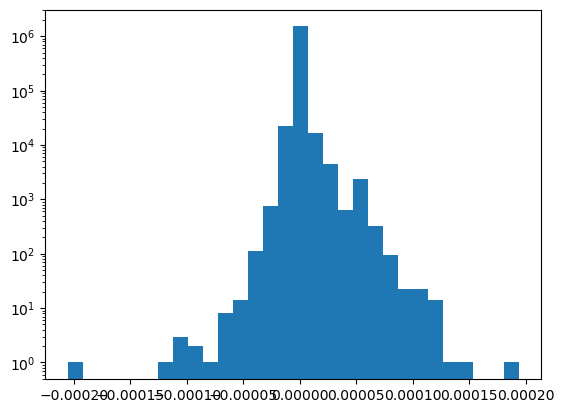

In [79]:
plt.hist(p_cchat.flatten()-p_c_c_hat_dhayaa.flatten(), bins=30, log=1)

In [35]:
p_c_hat_bal_dhayaa = np.load('/project/chihway/dhayaa/DECADE/For_Raul/p_chat_balrog.npy')
p_c_c_hat_dhayaa = np.load('/project/chihway/dhayaa/DECADE/For_Raul/p_c_chat.npy')